In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [5]:
# Define dataset paths and their corresponding passenger counts
dataset_info = {
    "dataset_128_a.csv": 128,
    "dataset_128_b.csv": 128,
    "dataset_250_a.csv": 250,
    "dataset_250_b.csv": 250,
    "dataset_300_a.csv": 300,
    "dataset_300_b.csv": 300,
    "dataset_350_a.csv": 350,
    "dataset_350_b.csv": 350,
}

# Load and combine all datasets with a new column
dfs = []
for file_name, passenger_count in dataset_info.items():
    df_temp = pd.read_csv(f"C:/Users/USER/Desktop/A/{file_name}")
    df_temp["Passenger_Count"] = passenger_count
    dfs.append(df_temp)

# Concatenate all into one DataFrame
luggage_dataset = pd.concat(dfs, ignore_index=True)

# Use the combined dataset
df = luggage_dataset.copy()

# Drop rows with missing Bag_ID
df = df.dropna(subset=["Bag_ID"])

# Convert boolean and fill missing values
df["Handled_by_SLHS"] = df["Handled_by_SLHS"].fillna(False).astype(bool).astype(int)

# Drop unnecessary columns
df = df.drop(columns=[
    'Bag_ID', 'Phone_Number', 'Reservation_ID', 'Claim_Option', 'Flight_Number', 
    'Delivery_Address', 'Password'
], errors='ignore')

# Drop rows with missing target values
df = df.dropna(subset=["Estimated_Arrival_Time", "Actual_Arrival_Time"])


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/USER/Desktop/A/dataset_128_a.csv'

C:\Users\USER\AppData\Local\Temp\ipykernel_29028\1026915776.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Handled_by_SLHS'] = dataset['Handled_by_SLHS'].fillna(False).astype(bool).astype(int)
Training Models:   0%|          | 0/4 [00:00<?, ?model/s]

Linear Regression: Average R² Score = 1.0000


Training Models: 100%|██████████| 4/4 [00:01<00:00,  3.23model/s]

Random Forest: Average R² Score = 0.9984
Support Vector Regressor: Average R² Score = 0.9963
K-Nearest Neighbors: Average R² Score = 0.9928

Best performing model: Linear Regression with R² Score of 1.0000


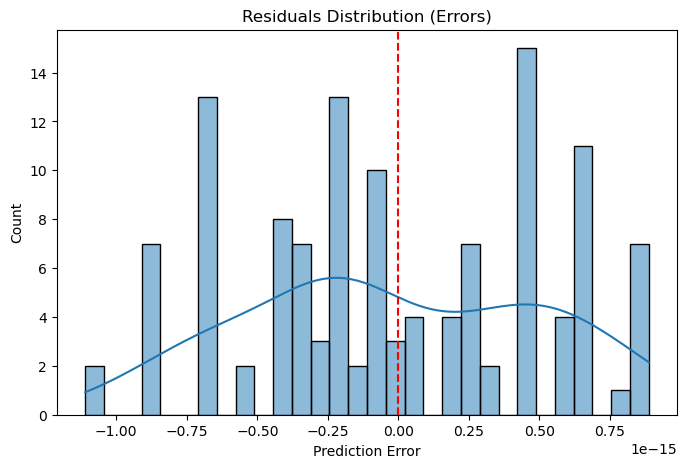

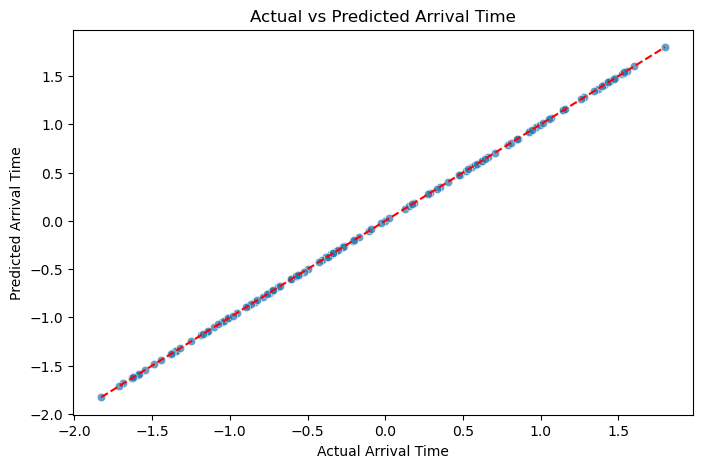

Final MAE: 0 hours, 0 minutes
Test MAE: 0.0000 minutes


In [59]:
# Define features
features = [
    'Handled_by_SLHS', 'Cluster_Size', 'Pickup_Gate', 
    'Luggage_Status', 'Pickup_Time', 'Flight_Arrival_Time'
]
df = df.dropna(subset=features)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['Pickup_Gate', 'Luggage_Status'], drop_first=True)

# Target and features
y = df['Estimated_Arrival_Time'].values
X = df.drop(columns=['Estimated_Arrival_Time', 'Actual_Arrival_Time'])


In [9]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Normalize target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()


C:\Users\USER\AppData\Local\Temp\ipykernel_29028\3514582384.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Handled_by_SLHS'] = dataset['Handled_by_SLHS'].fillna(False).astype(bool).astype(int)


    Handled_by_SLHS  Check_In_Timestamp  Final_Checkpoint_Timestamp  \
12                0          1741112940                  1741119060   
13                0          1741071060                  1741077420   
14                0          1741051920                  1741061280   
15                0          1741112940                  1741123740   
16                0          1741112220                  1741114680   

    Check_In_Hour  Check_In_DayOfWeek  Time_in_Transit_Minutes  
12           18.0                 1.0                      102  
13            6.0                 1.0                      106  
14            1.0                 1.0                      156  
15           18.0                 1.0                      180  
16           18.0                 1.0                       41  


Training Models:   0%|          | 0/4 [00:00<?, ?model/s]


NameError: name 'trainx' is not defined

In [3]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_results = {}

for name, model in tqdm(models.items(), desc="Training Models", unit="model"):
    cv_scores = cross_val_score(model, X_scaled, y_scaled, cv=kf, scoring="r2")
    model_results[name] = np.mean(cv_scores)
    print(f"{name}: Average R² Score = {model_results[name]:.4f}")


Training Models:   0%|          | 0/4 [00:00<?, ?model/s]


NameError: name 'X_scaled' is not defined

In [ ]:
# Select best model
best_model_name = max(model_results, key=model_results.get)
best_model = models[best_model_name]
best_model.fit(X_scaled, y_scaled)

print(f"\n✅ Best Model: {best_model_name} with R² = {model_results[best_model_name]:.4f}")

# Predict and inverse transform
y_pred_scaled = best_model.predict(X_scaled)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = df["Actual_Arrival_Time"].values


In [ ]:
# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
mae_hours, mae_minutes = divmod(mae, 60)

print(f"🕓 Final MAE: {int(mae_hours)} hours, {int(mae_minutes)} minutes")


In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Arrival Time")
plt.ylabel("Predicted Arrival Time")
plt.title("Actual vs Predicted Arrival Time")
plt.show()


In [ ]:
residuals = y_true - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='dashed')
plt.title("Residuals Distribution")
plt.xlabel("Prediction Error")
plt.show()
